<a href="https://colab.research.google.com/github/yvvvan/BMC_ELO/blob/main/ELO_tenhou.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import csv
from pandas import Series,DataFrame
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns
import copy
import itertools
from sklearn.cluster import KMeans


plt.rcParams['axes.unicode_minus']=False

## PlayYear Filter

In [2]:
filter_old = ["2019","2020","2021"]
filter_club_up = ["2022/1/","2022/2/","2022/3/","2022/4/","2022/5/"] #Julian:"你们来俱乐部以后的成绩"
filter_2023 = ["2022/6/","2022/7/","2022/8/","2022/9/","2022/10/","2022/11/","2022/12/1","2022/12/8"] #圣诞节以后的成绩(2023ClubRating)

filter = filter_old+filter_club_up


## Read Data

In [3]:
mahjong_game = {}
mahjong_player = {}

url = 'https://raw.githubusercontent.com/yvvvan/BMC_ELO/main/mahjong_riichi.csv'
df1 = pd.read_csv(url)
for index, row in df1.iterrows():
    if row['Date'][:4] in filter:
        continue
    elif row['Date'][:7] in filter:
        continue
    elif row['Date'][:8] in filter:
        continue
    elif row['Date'] in filter:
        continue
    else:
        date = row[1]
        id = row[2]
        player = int(row['PlayerId'])
        points = float(row['Points'])
        score = float(row['Score'])
        rank = int(row['Rank'])
        if id not in mahjong_game:
            mahjong_game[id]={}
            mahjong_game[id]["date"] = date
            mahjong_game[id]["result"] = {}
        if player not in mahjong_player:
            mahjong_player[player]={}
            mahjong_player[player]["r"] = 1200
            mahjong_player[player]["rs"] = [1200]
            mahjong_player[player]["i"] = 0
            mahjong_player[player]["s"] = []
            mahjong_player[player]["lastplay"] = ""
        mahjong_player[player]["i"] += 1
        mahjong_player[player]["s"] += [score]
        mahjong_game[id]["result"][player] = (rank,points,score,mahjong_player[player]["i"])

url = 'https://raw.githubusercontent.com/yvvvan/BMC_ELO/main/mahjong_players.csv'
df2 = pd.read_csv(url)
for index, row in df2.iterrows():
    id = int(row['PlayerId'])
    name = row['Name']
    if id not in mahjong_player:
        continue
    mahjong_player[id]["n"] = name

## Tenhou R-Value

In [4]:
def calculate_R(rate, count, rank, score, rates_all, uma_type = 0, w=0.5, hanchan=60, q=20, correction=30):
    # 試合数補正 r
    #w = 0.2
    # if count < hanchan: #400
    #     w = 1 - count * (1-w)/hanchan #0.002

    # 対戦結果 u
    ## 天凤段位战
    if uma_type == 0:
        uma = [30, 10, -10, -30]
        u = uma[rank-1]
    
    ## 天凤雀庄战
    elif uma_type == 1:
        u = score
    
    ## 前30半庄补正10
    elif uma_type >= 2:
        u = score
        if count <= 30:
            u += correction

    # 補正値 b
    r_avg = sum(rates_all)/4
    if r_avg < 1500:
        r_avg = 1500
    r = rate
    ## 个人rate<1500时,补至1500
    if uma_type == 3 and r < 1500:
      r = 1500

    b = (r_avg - r)/q

    return rate+w*(u+b)

## Calculate R

In [5]:
def get_r_value_all(type=2, w=0.5, q=40, hanchan=60 , initial=900, correction=30):
    player_result = copy.deepcopy(mahjong_player)

    
    # initial 
    for p in player_result:
      player_result[p]["r"] = initial
      player_result[p]["rs"] = [initial]

    avg_p = {1:[],2:[],3:[],4:[]}
    for game in mahjong_game:
        
        players = []
        results = {}  # results := { id:(rank,points,score(uma),#hanchan) } 
        old_r = []
        new_r = []
        
        # get all date
        for p in mahjong_game[game]["result"]:
            players.append(p)
            results[p] = mahjong_game[game]["result"][p]
            # add score(uma) to rank-class -> to calculate the avg_score for each rank
            avg_p[mahjong_game[game]["result"][p][0]].append(mahjong_game[game]["result"][p][2]) 
            rate = player_result[p]["r"]
            old_r.append(player_result[p]["r"])

        # calculate new r for each player
        for p in mahjong_game[game]["result"]:
            #calculate_R(rate, count, rank, rates_all, score, uma_type = 0, w=0.4,q=20, hanchan=60)
            r = calculate_R(player_result[p]["r"], results[p][3], results[p][0], results[p][2], old_r, type, w, hanchan, q, correction)
            new_r.append(r)

        # update r
        for i in range(4):
            player_result[players[i]]["r"] = round(new_r[i])
            player_result[players[i]]["rs"] += [round(new_r[i])]

    # finished
    ranking = sorted(player_result, key = lambda i: player_result[i]['r'], reverse=True)
    r_results = {"Player":[],"R-Value":[],"#Hanchan":[],"R-change":[]}
    for p in ranking:
        if p != 0:
            r_results["Player"].append(player_result[p]['n'])
            r_results["R-Value"].append(round(player_result[p]['r']))
            r_results["#Hanchan"].append(player_result[p]['i'])
            r_results["R-change"].append(player_result[p]['rs'])
    r_results["avg"] = avg_p
    return r_results

## Result

In [23]:
# type 0:段位战；1:雀庄战；2:1+前30半庄+修正；3:2+补正时不足1500的R按1500算
# 最初的半庄数量补正为1，直线下降，hanchan个半庄后，下降至w，之后不变。
# q为平均R补正的分母，q越小，对R值小的玩家的补正越大（越有利）

data = get_r_value_all(type=2, w=0.5, q=40, initial=900, correction=40)


df = pd.DataFrame(np.array([data["Player"],data["R-Value"],data["#Hanchan"]]).T)
pd.set_option('display.max_rows', df.shape[0]+1)
df

,0,1,2
0,JL,1764,84
1,YF,1758,86
2,JY,1723,66
3,WJ,1721,36
4,ZK,1643,57
5,NRK,1632,33
6,CH,1623,41
7,PG,1611,31
8,TM,1599,60
9,SAM,1596,48


### Player R-Changes

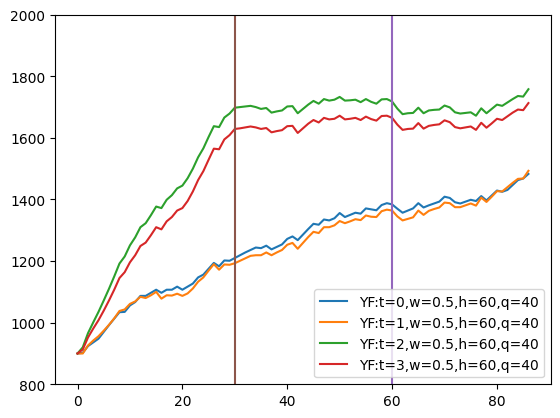

In [24]:
ps = ['YF']
ts = [0,1,2,3]
ws = [0.5]
hs = [60]
qs = [40]
for (i,(h,w,t,q)) in enumerate(itertools.product(hs,ws,ts,qs)):
    d = get_r_value_all(type=t, w=w, q=q, initial=900, correction=40 )
    for (j,p) in enumerate(d["Player"]):
        if p not in ps:
            continue
        y = d["R-change"][j]
        plt.plot(range(len(y)),y, label="%s:t=%d,w=%.1f,h=%d,q=%d"%(p,t,w,h,q))
plt.plot([h,h],[0,2000])
plt.plot([30,30],[0,2000])
plt.ylim((800,2000))
plt.legend()
plt.show()


### R-Value Boxplot

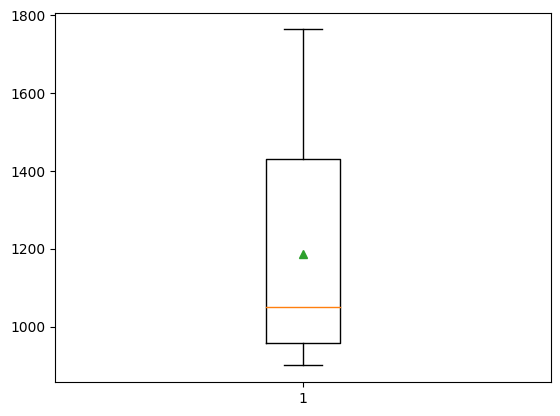

In [25]:
#@title All Players
plt.boxplot(data["R-Value"], showmeans=True)
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


level 0 900 1088
level 1 1129 1295
level 2 1347 1559
level 3 1596 1764


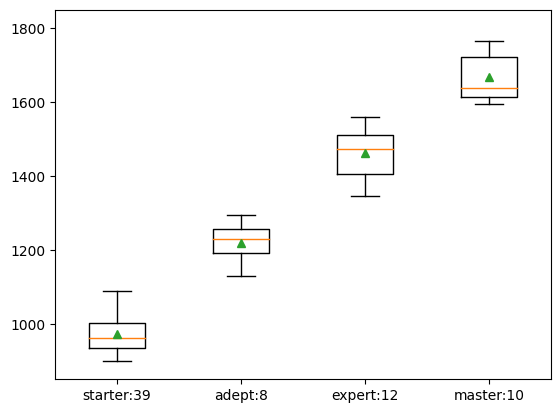

In [26]:
#@title Skill-Level(KMean)
x = data["R-Value"]
y = np.array(x).reshape(-1,1)
km = KMeans(n_clusters=4, random_state=1)
result = km.fit_predict(y)
r_min = min(x)//100*100-50
r_max = (max(x)//100+1)*100+50
# level
R_level={0:[],1:[],2:[],3:[]}
R_level_sorted={0:[],1:[],2:[],3:[]}
for i in range(len(result)):
    R_level[result[i]].append(int(y[i]))

R_level_mean = [np.mean(R_level[0]),np.mean(R_level[1]),np.mean(R_level[2]),np.mean(R_level[3])]
sorted_id = sorted(range(len(R_level_mean)), key=lambda k: R_level_mean[k])
for i in range(4):
    R_level_sorted[i] = R_level[sorted_id[i]]
    print('level',i, min(R_level_sorted[i]),max(R_level_sorted[i]))

R_level_name = ["starter:%i"%len(R_level_sorted[0]), "adept:%i"%len(R_level_sorted[1]), "expert:%i"%len(R_level_sorted[2]), "master:%i"%len(R_level_sorted[3])]

plt.boxplot([R_level_sorted[0],R_level_sorted[1], R_level_sorted[2], R_level_sorted[3]],showmeans=True)
plt.xticks(range(1,4+1),R_level_name)
plt.ylim((r_min,r_max))
plt.show()


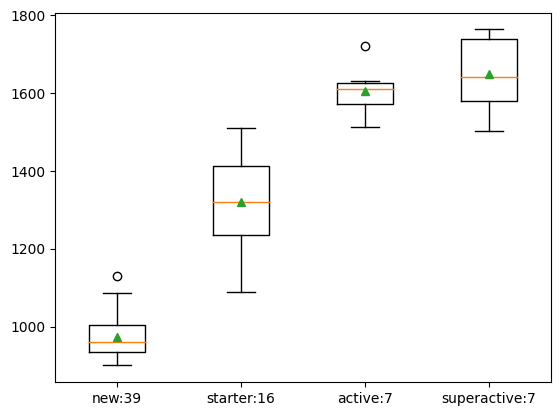

In [27]:
#@title Aktive Group
x = data["#Hanchan"]
y = data["R-Value"]
r_newplayer = []
r_midplayer = []
r_activeplayer = []
r_superactiveplayer = []
for i in range(len(y)):
    if x[i] < 10:
        r_newplayer.append(y[i])
    elif x[i] < 30:
        r_midplayer.append(y[i])
    elif x[i] < 55:
        r_activeplayer.append(y[i])
    elif x[i] < 10000:
        r_superactiveplayer.append(y[i])
z = ["new:%i"%len(r_newplayer), "starter:%i"%len(r_midplayer), "active:%i"%len(r_activeplayer), "superactive:%i"%len(r_superactiveplayer)]

plt.subplots_adjust(hspace = 0.3)
plt.boxplot([r_newplayer,r_midplayer, r_activeplayer, r_superactiveplayer], showmeans=True)
plt.xticks(range(1,len(z)+1),z)
plt.show()

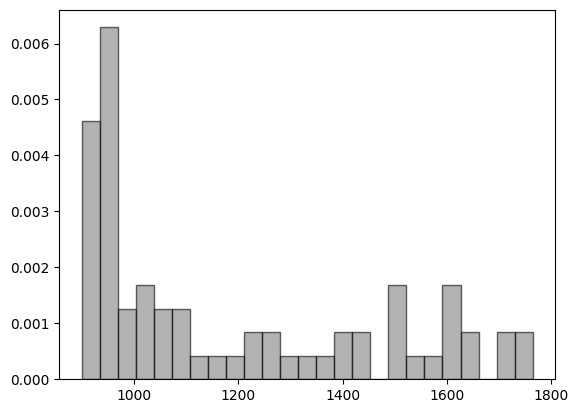

In [28]:
#@title Distribution
num_bins = 25
x = data["R-Value"]
mu = np.mean(x) 
sigma = np.std(x) 
n, bins, patches = plt.hist(x, num_bins,density=True, edgecolor="black",facecolor='gray', alpha=0.6)
#y = norm.pdf(bins, mu, sigma) 
#plt.plot(bins, y, 'g--') 
plt.show()

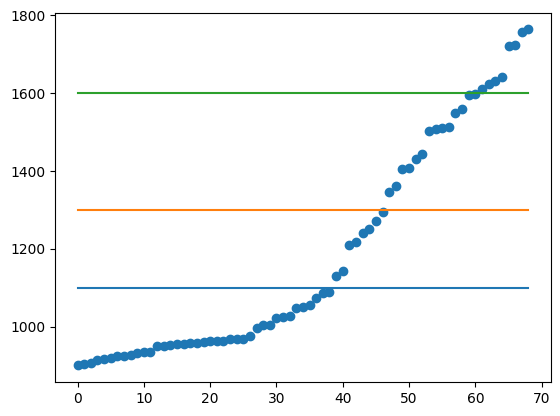

In [29]:
x = data["R-Value"]
plt.scatter(range(len(x)),x[::-1])
plt.plot(range(len(x)),[1100]*len(x))
plt.plot(range(len(x)),[1300]*len(x))
plt.plot(range(len(x)),[1600]*len(x))
plt.show()

### Average Score for Different Ranking

In [12]:
print("avg_score_different_ranking\nRank 1: %.2f\nRank 2: %.2f\nRank 3: %.2f\nRank 4: %.2f"%(np.mean(data["avg"][1]),np.mean(data["avg"][2]),np.mean(data["avg"][3]),np.mean(data["avg"][4])))

avg_score_different_ranking
Rank 1: 33.30
Rank 2: 9.26
Rank 3: -10.56
Rank 4: -32.31


### Active Group and Avg_Score

In [13]:
scores = [[],[],[],[]]
count = [0,0,0,0]
hanchan = [0,0,0,0]
z = ["new","starter","active","superactive"]
mean_scores = []
mean_hanchan = []
for p in mahjong_player:
    i = mahjong_player[p]['i']
    if i < 10:
      d = 0
    elif i < 30:
      d = 1
    elif i < 55:
      d = 2
    elif i < 10000:
      d = 3
    scores[d] += mahjong_player[p]['s']
    hanchan[d] += i
    count[d] += 1

for i in range(len(scores)):
  mean_scores += [round(np.mean(scores[i]),2)]
  mean_hanchan += [round(hanchan[i]/count[i],2)]
df = pd.DataFrame(np.array([z,mean_hanchan,mean_scores]).T)
df.columns = ['Active_Group', 'Avg_Played_Hanchan', 'Avg_Score']
df

,Active_Group,Avg_Played_Hanchan,Avg_Score
0,new,3.33,-10.47
1,starter,17.88,-2.29
2,active,39.0,1.1
3,superactive,68.0,3.61


## Parameter Choosing

### Distribute of all R-Values

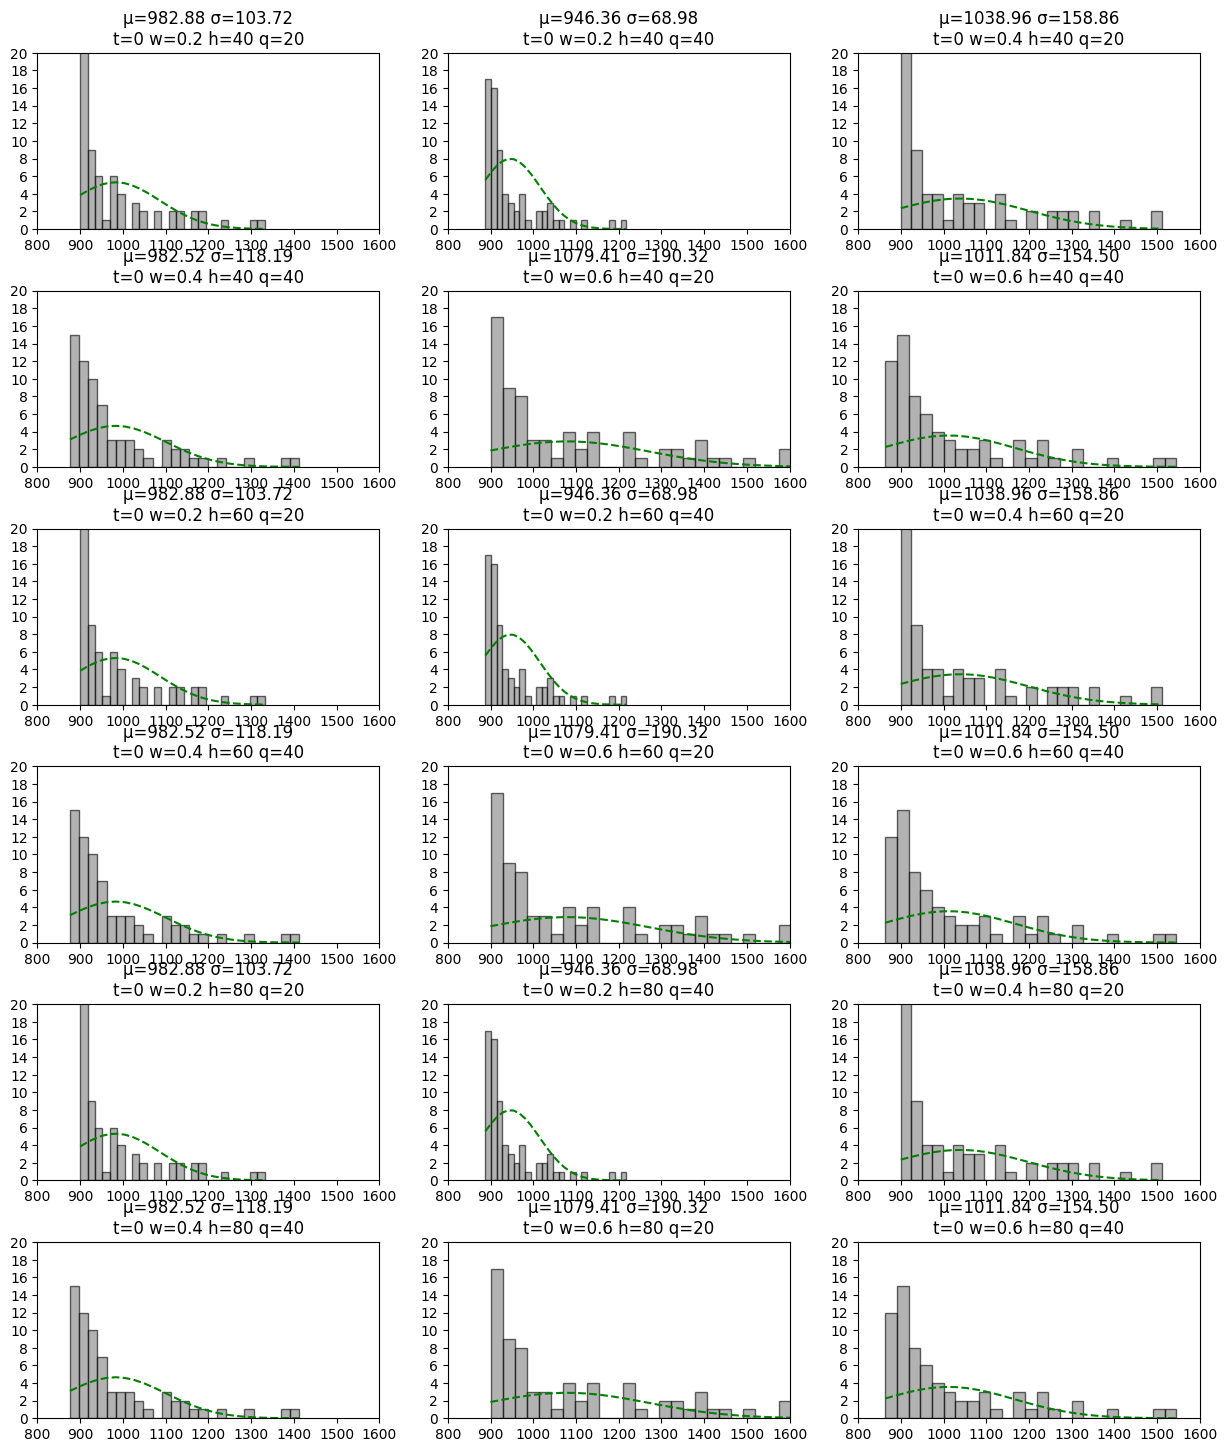

In [14]:
num_bins = 25
ts = [0]
ws = [0.2,0.4,0.6]
hs = [40,60,80]
qs = [20,40]
total = len(ts)*len(ws)*len(hs)*len(qs)
plt.figure(figsize=(15,3*total/2))
r_min = min(get_r_value_all()['R-Value'])//100*100
r_max = max(get_r_value_all()['R-Value'])//100*100

for (i,(h,w,t,q)) in enumerate(itertools.product(hs,ws,ts,qs)):

    data = get_r_value_all(type=t, w=w, q=q, hanchan=h )['R-Value']

    plt.subplot(int(total/2), 3, int(i+1))
    plt.subplots_adjust(hspace = 0.35)
    mu =np.mean(data) 
    sigma =np.std(data) 
    n, bins, patches = plt.hist(data, num_bins, edgecolor="black",facecolor='gray', alpha=0.6)
    y = norm.pdf(bins, mu, sigma) 
    plt.plot(bins, y*len(data)*20, 'g--') 
    plt.yticks(np.arange(0, 25, 2))
    plt.ylim((0,20))
    plt.xlim((r_min,r_max))
    plt.title("μ=%.2f σ=%.2f\nt=%d w=%.1f h=%d q=%d"%(mu,sigma,t,w,h,q))
plt.show()

### R-Value Boxplot: Different Active Groups

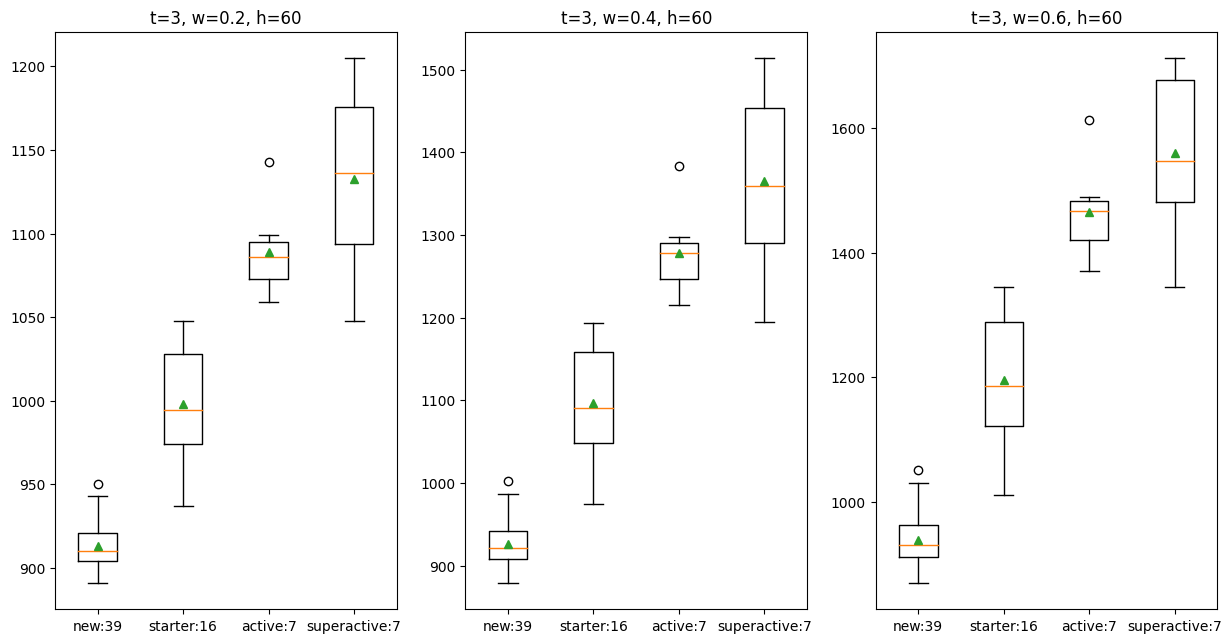

In [15]:
ts = [3]
ws = [0.2,0.4,0.6]
hs = [60]
total = len(ts)*len(ws)*len(hs)
plt.figure(figsize=(15,5*total/2))
x = get_r_value_all()["#Hanchan"]
for (i,(h,w,t)) in enumerate(itertools.product(hs,ws,ts)):
    plt.subplot(int(total/3), 3, int(i+1))
    y = get_r_value_all(type=t, w=w, hanchan=h)["R-Value"]
    r_newplayer = []
    r_midplayer = []
    r_activeplayer = []
    r_superactiveplayer = []
    for i in range(len(y)):
        if x[i] < 10:
            r_newplayer.append(y[i])
        elif x[i] < 30:
            r_midplayer.append(y[i])
        elif x[i] < 55:
            r_activeplayer.append(y[i])
        elif x[i] < 10000:
            r_superactiveplayer.append(y[i])
    z = ["new:%i"%len(r_newplayer), "starter:%i"%len(r_midplayer), "active:%i"%len(r_activeplayer), "superactive:%i"%len(r_superactiveplayer)]

    plt.subplots_adjust(hspace = 0.3)
    plt.boxplot([r_newplayer,r_midplayer, r_activeplayer, r_superactiveplayer], showmeans=True)
    plt.xticks(range(1,len(z)+1),z)
    plt.title("t=%d, w=%.1f, h=%d"%(t,w,h))

### R-Value: Different Skill-Level

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[1345.91666667]
 [ 970.76666667]
 [1538.125     ]
 [1110.36363636]]
30 11 12 16
mean_gain: 165.8895505296307 57.23648226285357 -118.49208160935939 -266.5723950914868
mean_adjustment: [16.58895505296307, 5.723648226285357, -11.84920816093594, -26.657239509148678]
mean_score: [-14.704109589041094, -5.633333333333334, -2.1134883720930233, 2.508875]
mean_change: [1.884845463921975, 0.09031489295202366, -13.962696533028963, -24.148364509148678]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[ 943.4       ]
 [1484.25      ]
 [1247.41666667]
 [1045.        ]]
30 11 12 16
mean_gain: 147.52481211634444 69.99496221662469 -82.41829878484631 -264.54098893949254
mean_adjustment: [7.376240605817221, 3.4997481108312343, -4.120914939242316, -13.227049446974627]
mean_score: [-14.704109589041098, -5.633333333333333, -2.1134883720930233, 2.508875]
mean_change: [-7.327868983223876, -2.1335852225020986, -6.234403311335339, -10.718174446974627]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[1355.30769231]
 [ 945.07692308]
 [1145.16666667]
 [1535.4       ]]
39 12 13 5
mean_gain: 118.4358164983165 -33.22768439356615 -195.10444735120993 -330.48421235253295
mean_adjustment: [2.9608954124579125, -0.8306921098391538, -4.877611183780248, -8.262105308813323]
mean_score: [-11.043181818181818, -4.413197969543147, 0.42618110236220474, 6.536474164133739]
mean_change: [-8.082286405723906, -5.243890079382301, -4.451430081418043, -1.7256311446795847]


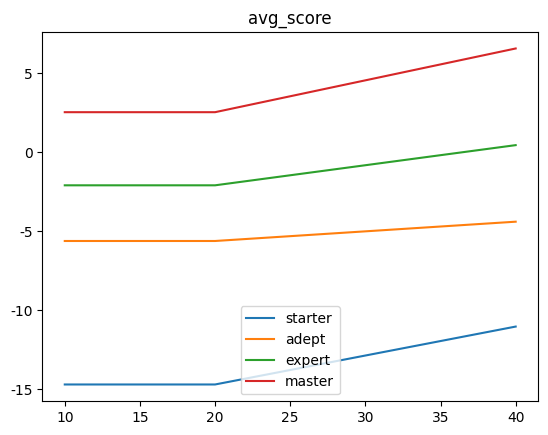

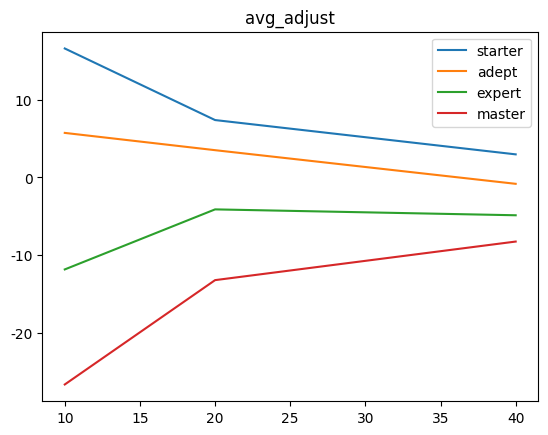

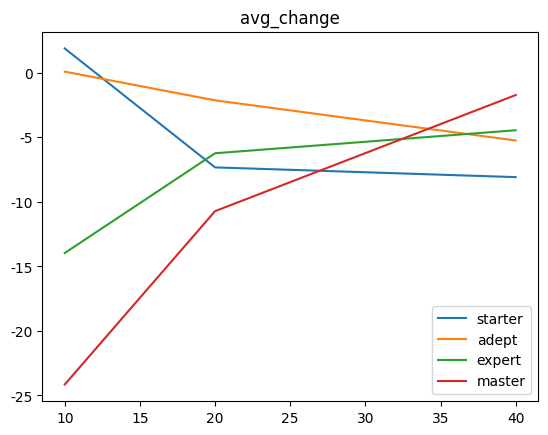

In [16]:
q=10
avg_results_all = [[],[],[],[]]
avg_adjustments_all = [[],[],[],[]]

qs = [10,20,40]
for q in qs:
    data = get_r_value_all(type=2, w=0.4, hanchan=60, q=q)

    x = data["R-Value"]
    y = np.array(x).reshape(-1,1)
    km = KMeans(n_clusters=4, random_state=1)
    result = km.fit_predict(y)
    print(km.cluster_centers_)

    # level
    R_level={0:[],1:[],2:[],3:[]}
    R_level_sorted={0:[],1:[],2:[],3:[]}
    for i in range(len(result)):
        R_level[result[i]].append(int(y[i]))
    
    R_level_mean = [np.mean(R_level[0]),np.mean(R_level[1]),np.mean(R_level[2]),np.mean(R_level[3])]
    sorted_id = sorted(range(len(R_level_mean)), key=lambda k: R_level_mean[k])
    for i in range(4):
        R_level_sorted[i] = R_level[sorted_id[i]]

    R_level_name=["starter","adept","expert","master"]
    print(len(R_level_sorted[0]),len(R_level_sorted[1]),len(R_level_sorted[2]),len(R_level_sorted[3]))

    # plt.boxplot([R_level_sorted[0],R_level_sorted[1], R_level_sorted[2], R_level_sorted[3]],showmeans=True)
    # plt.xticks(range(1,4+1),R_level_name)
    # plt.ylim((1200,1800))
    # plt.show()

    # simulate
    simulate_gain={0:[],1:[],2:[],3:[]} # R_avg - R
    for _ in range(10000):
        a = np.random.choice(x, size=4, replace=False)
        for p in a:
            gain = (sum(a))/4 - p
            if p in R_level_sorted[0]:
                simulate_gain[0].append(gain)
            elif p in R_level_sorted[1]:
                simulate_gain[1].append(gain)
            elif p in R_level_sorted[2]:
                simulate_gain[2].append(gain)
            elif p in R_level_sorted[3]:
                simulate_gain[3].append(gain)
    print("mean_gain:",np.mean(simulate_gain[0]),np.mean(simulate_gain[1]),np.mean(simulate_gain[2]),np.mean(simulate_gain[3]))
    adjustment = [np.mean(simulate_gain[0])/q,np.mean(simulate_gain[1])/q,np.mean(simulate_gain[2])/q,np.mean(simulate_gain[3])/q]
    print("mean_adjustment:",adjustment)

    result_level = [[],[],[],[]]
    rrr = [[],[],[],[]]
    for i in range(len(data["Player"])):
        p = data["Player"][i]
        r = data["R-Value"][i]
        cla = km.predict(np.array([r]).reshape(1,-1))
        rrr[int(cla)] += [r]
        for pp in mahjong_player:
            if pp == 0:
                continue
            if p == mahjong_player[pp]['n']:
                result_level[int(cla)] += mahjong_player[pp]['s']
    rrr_means = []
    for i in range(4):
        rrr_means.append(np.mean(rrr[i]))

    sorted_id = sorted(range(len(rrr_means)), key=lambda k: rrr_means[k])
    avg_score = list(map( lambda i:np.mean(result_level[sorted_id[i]]), range(4) ))
    print("mean_score:", avg_score)
    print("mean_change:",list(map( lambda i:avg_score[i]+adjustment[i], range(4) )))

    for i in range(4):
        avg_results_all[i].append(avg_score[i])
        avg_adjustments_all[i].append(adjustment[i])
    

for i in range(4):
    plt.plot(qs, np.array(avg_results_all[i]),label=R_level_name[i])
plt.legend()
plt.title("avg_score")
plt.show()

for i in range(4):
    plt.plot(qs, np.array(avg_adjustments_all[i]),label=R_level_name[i])
plt.legend()
plt.title("avg_adjust")
plt.show()

for i in range(4):
    plt.plot(qs, np.array(avg_results_all[i])+np.array(avg_adjustments_all[i]),label=R_level_name[i])
plt.legend()
plt.title("avg_change")
plt.show()

